# Anomaly Detection

Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. It has many applications in business, from intrusion detection (identifying strange patterns in network traffic that could signal a hack) to system health monitoring (spotting a malignant tumor in an MRI scan), and from fraud detection in credit card transactions to fault detection in operating environments.

In this jupyter notebook we are going to take the credit card fraud detection as the case study for understanding this concept in detail.

What Are Anomalies?
Anomalies can be broadly categorized as:

- Point anomalies: A single instance of data is anomalous if it's too far off from the rest. Business use case: Detecting credit card fraud based on "amount spent."

- Contextual anomalies: The abnormality is context specific. This type of anomaly is common in time-series data. Business use case: Spending $100 on food every day during the holiday season is normal, but may be odd otherwise.

- Collective anomalies: A set of data instances collectively helps in detecting anomalies. Business use case: Someone is trying to copy data form a remote machine to a local host unexpectedly, an anomaly that would be flagged as a potential cyber attack.

Anomaly detection is similar to — but not entirely the same as — **noise removal** and **novelty detection**.

Novelty detection is concerned with identifying an unobserved pattern in new observations not included in training data like a sudden interest in a new channel on YouTube during Christmas, for instance.

Noise removal (NR) is the process of removing noise from an otherwise meaningful signal.

## Anomaly Detection Techniques

1. Simple Statistical Methods

The simplest approach to identifying irregularities in data is to flag the data points that deviate from common statistical properties of a distribution, including mean, median, mode, and quantiles. Let's say the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean. Traversing mean over time-series data isn't exactly trivial, as it's not static. You would need a rolling window to compute the average across the data points. Technically, this is called a rolling average or a moving average, and it's intended to smooth short-term fluctuations and highlight long-term ones. Mathematically, an n-period simple moving average can also be defined as a "low pass filter."

Challenges with Simple Statistical Methods
The low pass filter allows you to identify anomalies in simple use cases, but there are certain situations where this technique won't work. Here are a few:

The data contains noise which might be similar to abnormal behavior, because the boundary between normal and abnormal behavior is often not precise.

The definition of abnormal or normal may frequently change, as malicious adversaries constantly adapt themselves. Therefore, the threshold based on moving average may not always apply.

The pattern is based on seasonality. This involves more sophisticated methods, such as decomposing the data into multiple trends in order to identify the change in seasonality.

2. Machine Learning-Based Approaches

Below is a brief overview of popular machine learning-based techniques for anomaly detection.

### a.Density-Based Anomaly Detection
Density-based anomaly detection is based on the k-nearest neighbors algorithm.

Assumption: Normal data points occur around a dense neighborhood and abnormalities are far away.

The nearest set of data points are evaluated using a score, which could be Eucledian distance or a similar measure dependent on the type of the data (categorical or numerical). They could be broadly classified into two algorithms:

K-nearest neighbor: k-NN is a simple, non-parametric lazy learning technique used to classify data based on similarities in distance metrics such as Eucledian, Manhattan, Minkowski, or Hamming distance.

Relative density of data: This is better known as local outlier factor (LOF). This concept is based on a distance metric called reachability distance.

### b.Clustering-Based Anomaly Detection
Clustering is one of the most popular concepts in the domain of unsupervised learning.

Assumption: Data points that are similar tend to belong to similar groups or clusters, as determined by their distance from local centroids.

K-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

### c.Support Vector Machine-Based Anomaly Detection

A support vector machine is another effective technique for detecting anomalies.
A SVM is typically associated with supervised learning, but there are extensions (OneClassCVM, for instance) that can be used to identify anomalies as an unsupervised problems (in which training data are not labeled).
The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region.
Depending on the use case, the output of an anomaly detector could be numeric scalar values for filtering on domain-specific thresholds or textual labels (such as binary/multi labels).
In this jupyter notebook we are going to take the credit card fraud detection as the case study for understanding this concept in detail using the following Anomaly Detection Techniques namely

Isolation Forest Anomaly Detection Algorithm
Density-Based Anomaly Detection (Local Outlier Factor)Algorithm
Support Vector Machine Anomaly Detection Algorithm
Credit Card Fraud Detection
Problem Statement:
The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100 %
of the fraudulent transactions while minimizing the incorrect fraud classifications.

Observations
The data set is highly skewed, consisting of 492 frauds in a total of 284,807 observations. This resulted in only 0.172 %
fraud cases. This skewed set is justified by the low number of fraudulent transactions.

The dataset consists of numerical values from the 28 ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.

The ‘Time’ and ‘Amount’ features are not transformed data.

There is no missing value in the dataset.

In [1]:
#Import the required libraries

import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

from joblib import parallel_backend

In [2]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
data = pd.read_csv('../../datasets/creditcard_train.csv.gz')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,154640.0,-0.012102,0.707332,0.163334,-0.756498,0.590999,-0.653429,0.844608,-0.001672,-0.184399,...,-0.231385,-0.572415,0.042660,-0.360882,-0.494703,0.142657,0.235922,0.083758,7.13,0
1,139525.0,1.776151,-0.184642,-2.204096,1.191668,0.614461,-1.016525,0.919254,-0.387465,-0.318277,...,0.281190,0.530070,-0.232262,-0.342096,0.492355,-0.427682,-0.075228,-0.056755,150.00,0
2,69778.0,-1.083391,-4.440527,-1.399530,0.469764,-2.076458,-0.766137,1.601441,-0.709176,-1.288745,...,0.346463,-1.432833,-1.097063,0.505926,-0.140185,0.870190,-0.316982,0.227833,1302.49,0
3,48473.0,-0.518847,1.025087,-0.614624,-0.780959,2.474666,3.335055,0.046111,0.794249,-0.322448,...,-0.193099,-0.708348,0.145672,0.944217,-0.788017,0.039995,0.010804,0.254309,4.49,0
4,129350.0,-0.640421,0.212171,0.283341,-1.786916,2.616127,4.024863,-0.198897,0.937087,0.474428,...,0.167939,0.759218,-0.321412,0.767971,-0.084221,0.612936,0.074029,-0.033344,4.49,0


In [4]:
# Checking the missing values 
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

From the above table - There are no missing values in the dataset

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,94898.211518,-0.001137,-0.002024,-0.001333,0.000313,0.000202,0.000302,-0.000307,-0.001291,0.001995,...,0.000459,0.000360,0.000731,-0.000054,-0.000550,0.000072,-0.000405,0.000522,88.384784,0.001725
std,47489.931167,1.965794,1.658079,1.519820,1.416731,1.387295,1.336558,1.248395,1.198699,1.098649,...,0.740233,0.726146,0.625116,0.605084,0.521473,0.482197,0.407727,0.329701,253.066081,0.041503
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54253.750000,-0.919472,-0.600466,-0.890875,-0.846902,-0.691963,-0.768846,-0.553719,-0.208460,-0.640513,...,-0.228438,-0.542054,-0.162021,-0.354888,-0.317041,-0.326836,-0.070712,-0.052910,5.670000,0.000000
50%,84845.500000,0.017529,0.064591,0.180371,-0.020802,-0.054897,-0.273921,0.040482,0.022954,-0.050199,...,-0.029121,0.006539,-0.010594,0.041130,0.016344,-0.052065,0.001367,0.011266,22.000000,0.000000
75%,139365.000000,1.315404,0.804932,1.026038,0.743833,0.611243,0.398847,0.571020,0.326971,0.600147,...,0.186562,0.528738,0.147946,0.439173,0.350126,0.240930,0.091088,0.078266,77.500000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.083545,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000,1.000000


Text(0, 0.5, 'Frequency')

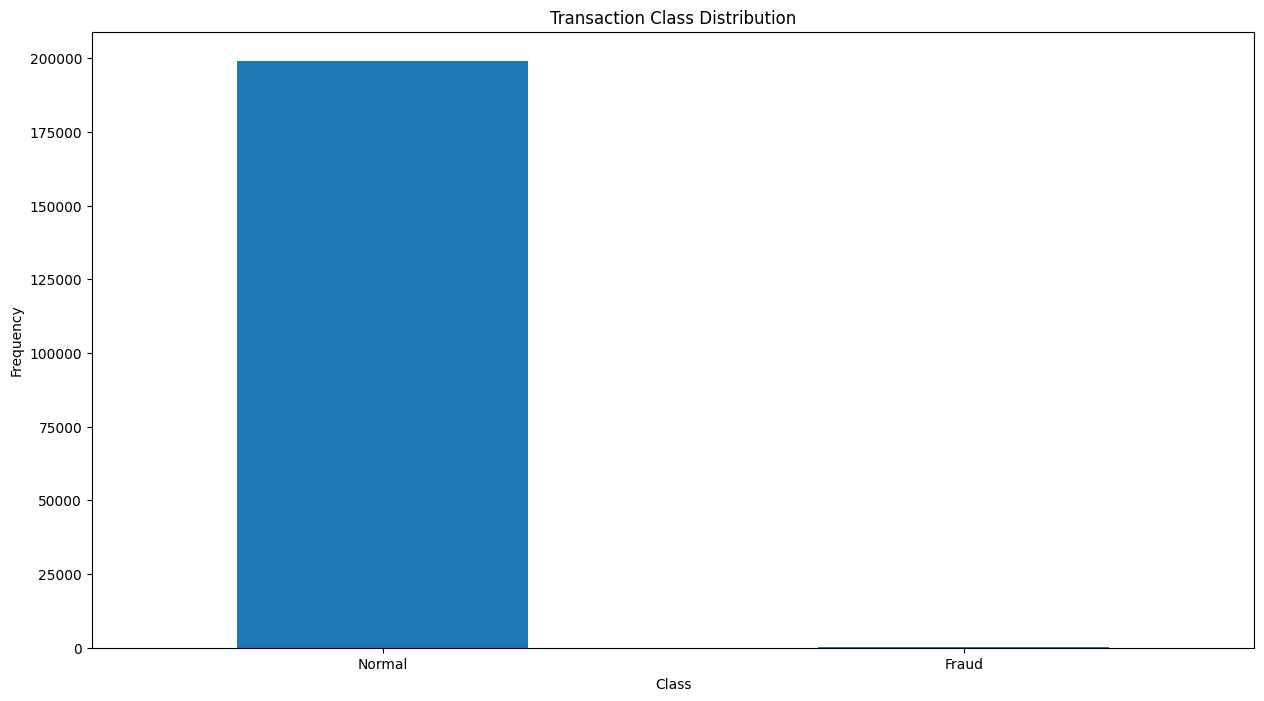

In [6]:
#Determine the number of fraud and valid transactions in the entire dataset

count_classes = data['Class'].value_counts() #pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
#Assigning the transaction class "0 = NORMAL  & 1 = FRAUD"
Normal = data[data['Class']==0]
Fraud = data[data['Class']==1]

In [8]:
Normal.shape

(199020, 31)

In [9]:
Fraud.shape

(344, 31)

In [10]:
#How different are the amount of money used in different transaction classes?
Normal.Amount.describe()

count    199020.000000
mean         88.332469
std         253.049486
min           0.000000
25%           5.710000
50%          22.000000
75%          77.445000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
#How different are the amount of money used in different transaction classes?
Fraud.Amount.describe()

count     344.000000
mean      118.651395
std       261.116789
min         0.000000
25%         1.000000
50%         7.585000
75%       100.367500
max      2125.870000
Name: Amount, dtype: float64

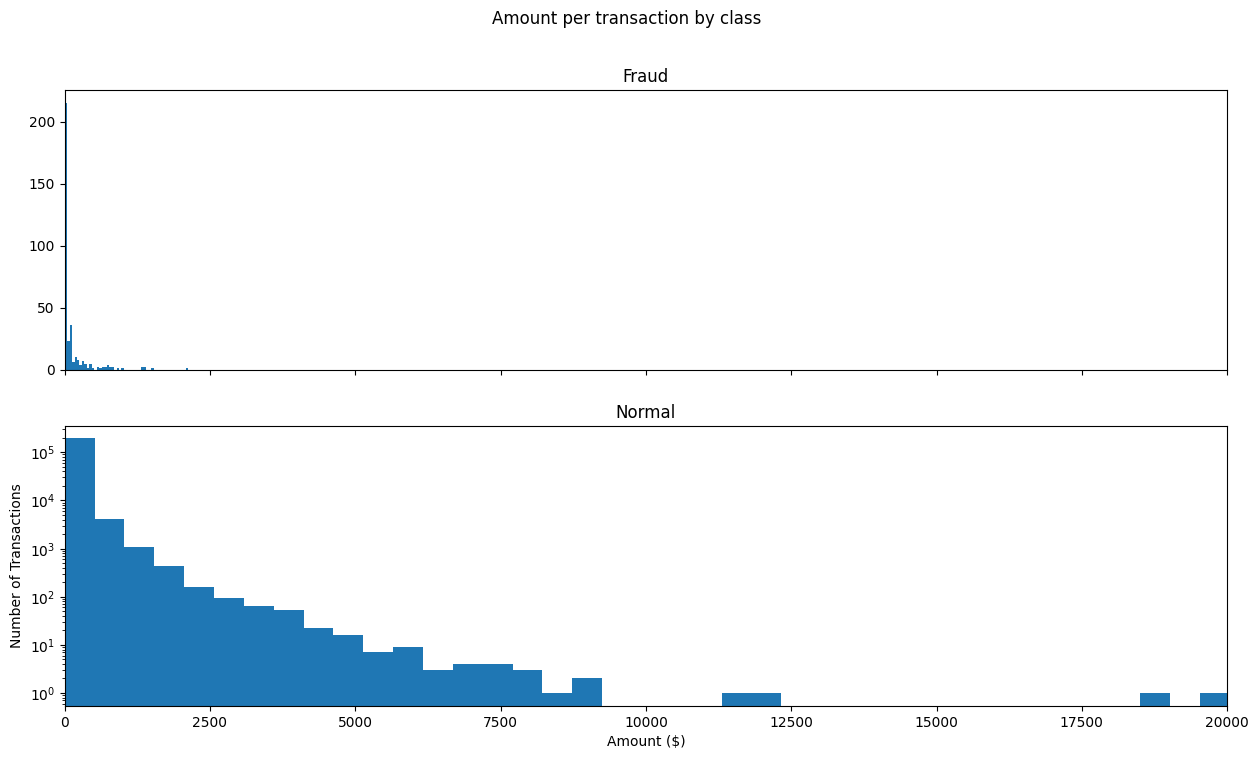

In [12]:
#Let's have a more graphical representation of the data

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

**Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.**

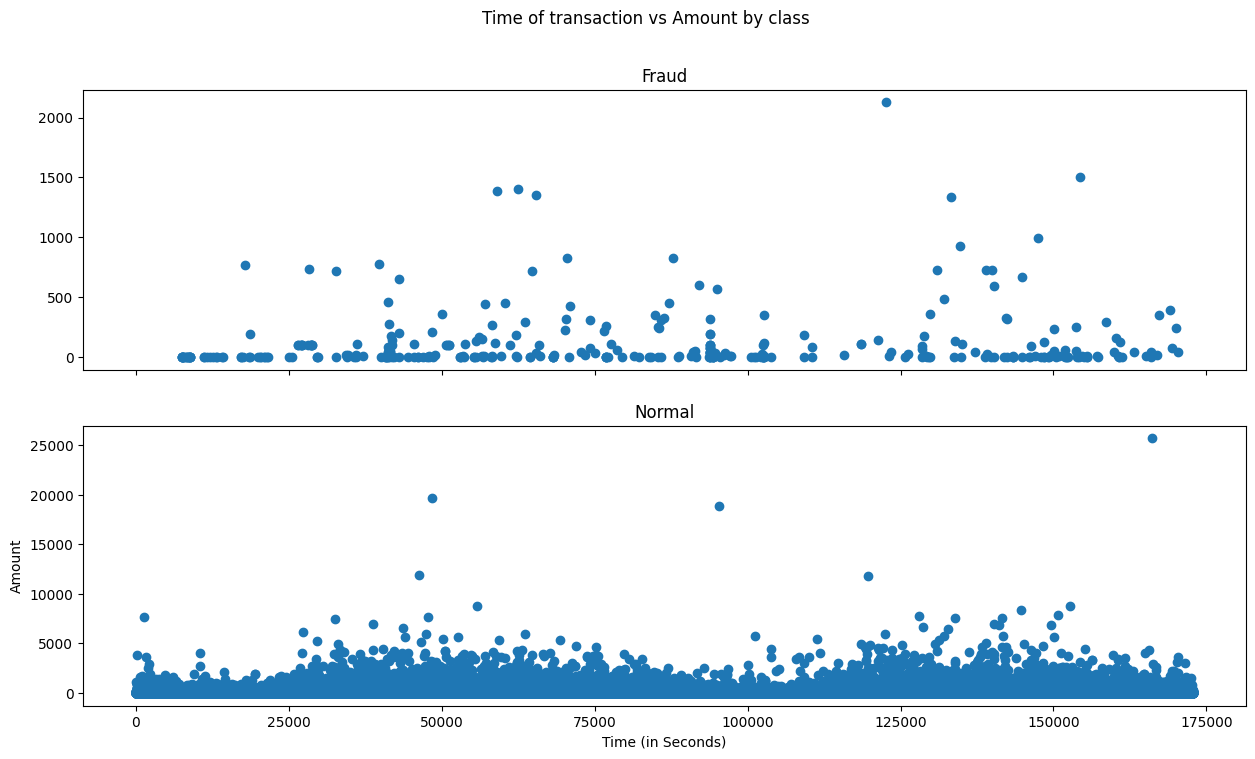

In [13]:
#Graphical representation of the data

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters here as per above observation. Now let us take a sample of the dataset for out modelling and prediction


In [14]:
data1= data.sample(frac = 0.1,random_state=RANDOM_SEED)
data1.shape

(19936, 31)

In [15]:
#Determine the number of fraud and valid transactions in the dataset.
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [16]:
#Now let us print the outlier fraction and no of Fraud and Valid Transaction cases

print(f'{outlier_fraction:.4f}%')
print(f'Fraud Cases : {len(Fraud)}')
print(f'Valid Cases : {len(Valid)}')

0.0018%
Fraud Cases : 35
Valid Cases : 19901


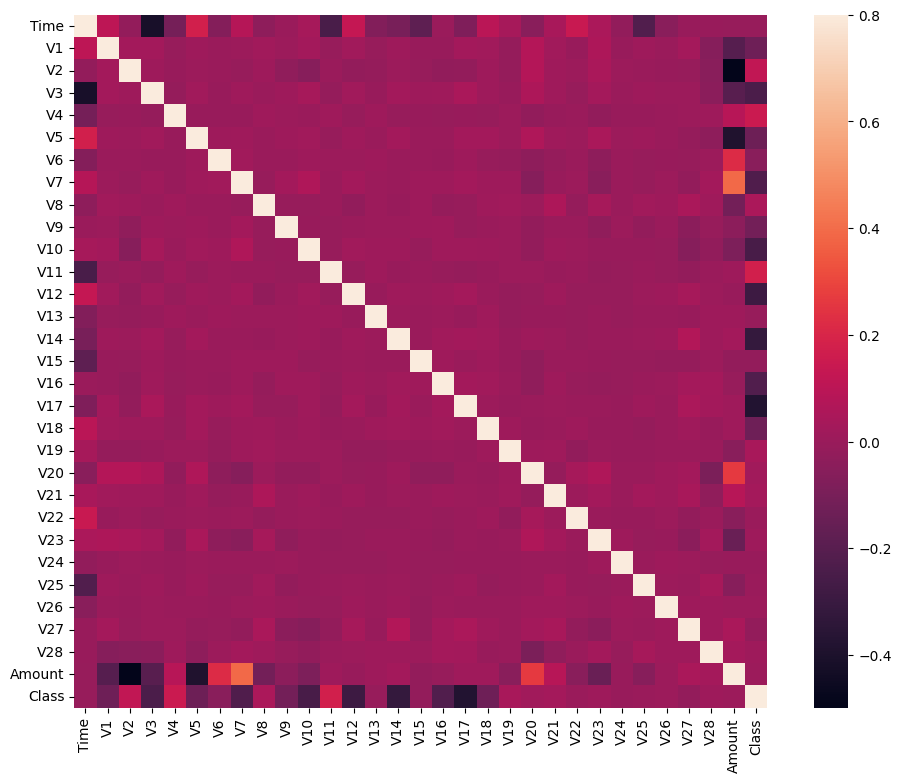

In [17]:
#Correlation Matrix

correlation_matrix = data1.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

The above correlation matrix shows that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.


In [18]:
#Get all the columns from the dataframe

columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(19936, 30)
(19936,)


Model Prediction

Now it is time to start building the model. The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

1. Isolation Forest Algorithm:
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

2. Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

Define the outlier detection methods

In [19]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
}

Fit the model

In [20]:
#Fit the model
with parallel_backend('loky', n_jobs=-1):
    n_outliers = len(Fraud)
    for i, (clf_name,clf) in enumerate(classifiers.items()):
        #Fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_prediction = clf.negative_outlier_factor_
        elif clf_name == "Support Vector Machine":
            clf.fit(X)
            y_pred = clf.predict(X)
        else:    
            clf.fit(X)
            scores_prediction = clf.decision_function(X)
            y_pred = clf.predict(X)
        #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        n_errors = (y_pred != Y).sum()
        # Run Classification Metrics
        print(f'{clf_name}: {n_errors}')
        print(f'Accuracy Score: {accuracy_score(Y,y_pred)}')
        print('Classification Report:')
        print(classification_report(Y,y_pred))

Isolation Forest: 45
Accuracy Score: 0.9977427768860353
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19901
           1       0.36      0.37      0.37        35

    accuracy                           1.00     19936
   macro avg       0.68      0.69      0.68     19936
weighted avg       1.00      1.00      1.00     19936

Local Outlier Factor: 71
Accuracy Score: 0.9964386035313002
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19901
           1       0.00      0.00      0.00        35

    accuracy                           1.00     19936
   macro avg       0.50      0.50      0.50     19936
weighted avg       1.00      1.00      1.00     19936

Support Vector Machine: 9711
Accuracy Score: 0.5128912520064205
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.51      0.6

Observations :

* Isolation Forest detected 69 errors versus Local Outlier Factor detecting 93 errors vs. SVM detecting 8411 errors

* Isolation Forest has a 99.75% more accurate than LOF of 99.67% and SVM of 70.46

* When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0

* So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.

* We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases